In [56]:
# Packages for data processing 
import numpy as np, pandas as pd, math, random, statistics
#Packages for webpage crawling
import requests as r
import re
from bs4 import BeautifulSoup as BS
#Packages for nature language processing
import spacy,pyinflect
from pyinflect import getAllInflections
import nltk,string,re,emoji
from collections import Counter
from nltk.corpus import stopwords as sw
from nltk.util import ngrams as ng
from nltk.tokenize import word_tokenize as tk
from nltk.stem import WordNetLemmatizer as wn
import gender_guesser.detector as gen
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
#Packages for machine learning (flair and bert_based model)
from flair.models import TARSClassifier
from flair.data import Sentence
import tweetnlp
import gensim
#Packages for LDA Visualisation
import pyLDAvis
import pyLDAvis.gensim_models
#Packages for Twitter API and configuration
import tweepy as tw, configparser  
#Packages about time
import time as t, datetime as dt, rfc3339
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
#Packages for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

#Packages for machine learning models
# Skleran classifiers
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,classification_report
import featuretools as ft
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# Keras classifiers for ANN
import keras_metrics
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding,LSTM
from tensorflow.keras import layers
from keras.utils import np_utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [57]:
# Reqest the webpages including the synonymsous words or meanings of these topics: car, buy, and drive
car_url='https://www.thesaurus.com/browse/car'
buy_url='https://www.thesaurus.com/browse/buy'
buying_url='https://www.thesaurus.com/browse/buying'
drive_url='https://www.thesaurus.com/browse/drive'

# Crawling the synonyms of four topics: (car, buy, buying, drive) from Thesurus.com
def keyword_extract(url_name,class_name):
    page_name=r.get(url_name)
    soup_name=BS(page_name.content,'html.parser')
    key_soup=soup_name.find('ul', class_=class_name).find_all('a')
    list_name=[]
    for key in key_soup:
        new_key=key['href'][8:].replace('%20',' ')
        list_name.append(new_key)
    return list_name

# I only captured the red-marked words which contain the most closed meanings as the chosen topics
car_sym=keyword_extract(car_url,'css-1xohnkh e1ccqdb60')[:14]
car_sym.insert(0,'car')
buy_sym=keyword_extract(buy_url,'css-wmtunb e1ccqdb60')[:4]
buy_sym.insert(0,'buy')
buying_sym=keyword_extract(buying_url,'css-1lj4erq e1ccqdb60')[:3]
buying_sym.insert(0,'buying')
buy_sym=buy_sym+buying_sym
drive_sym=keyword_extract(drive_url,'css-n85ndd e1ccqdb60')[:4]
drive_sym.insert(0,'drive')

#But there isn't such words like automobiling/automobiled or jeeping/jeeped, so it has to be deleted
car_sym.remove('ride')
car_sym.remove('auto')
car_sym.remove('machine')
car_sym.remove('motor')

# Altough I have got thirty words as required keywords for tweet requests, it is recommended to include different tenses or forms of words 
#, as many Twitter users will use them depending on different contents.
nlp = spacy.load('en_core_web_md')

buy_str=' '.join(buy_sym+['invest','shop','transact'])
buy_doc=nlp(buy_str)
buy_extension_list=[]
for num in range(len(buy_doc)):
    token = buy_doc[num]
    if token.tag_ in ['NN','VB','VBG','ABD','ADJ','ADV','VBN','VBZ']:
        buy_extension_list.append(token._.inflect('VB',inflect_oov=True))
buy_extension_list=[ele for ele in list(set(buy_extension_list)) if ele]

def extension(sym):
    sym_str=' '.join(sym)
    sym_token=nlp(sym_str)
    extension_list=[]
    for num in range(len(sym_token)):
        token = sym_token[num]
        if token.tag_ in ['NN','VB']:   
            if str(token)!=token._.inflect('VBD',inflect_oov=True)[:len(token)]:
                extension_list.append(token._.inflect('VBD',inflect_oov=True))              
            if str(token)!=token._.inflect('VBG',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBG',inflect_oov=True))
            if str(token)!=token._.inflect('VBN',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBN',inflect_oov=True))
            if str(token)!=token._.inflect('VBZ',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBZ',inflect_oov=True))
            if str(token)!=token._.inflect('VBP',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBP',inflect_oov=True))
    return extension_list

buy_sym=list(set(extension(buy_extension_list)+buy_extension_list))
buy_sym.append('acquisition')

drive_sym=list(set(extension(drive_sym)+drive_sym))

# According to car registration records of the UK from 2019 to 2022, the top 10 sales brands were selected as they might be mentioned more frequently than the other brands when talking about automative topics
brand_list=['Ford','BMW','Volkswagen','Mercedes-Benz','Audi','Vauxhall','Toyota','Kia','Hyundai','Land Rover']

#While searching for Google Trends data, various spellings or expressions that a user could use while posting about a car model were checked.
brand_abb=['VW','Mercedes','Voho','Landy','Bimmer','MBZ']

# The most popular Car sale Models in the UK, as a same replacement of the brand name: One model for one brand
brand_model=['fiesta','corolla','Series','polo','sportage','tucson','corsa','A-Class','discovery','A3']

# Name of car types when people are talking a series of car
car_type=['coupe','hatchback','sedan','sports','suv']

def df_generator(name,list):
    return pd.DataFrame({name:list})
#Put all the words into a dataframe sorted by different segements.
keywords=pd.concat([df_generator('Car',car_sym),
                    df_generator('Buy',buy_sym),
                    df_generator('Drive',drive_sym),
                    df_generator('Brand',brand_list),
                    df_generator('Brand Abbreviation',brand_abb),
                    df_generator('Brand Model',brand_model), 
                    df_generator('Car Type',car_type)],
                    axis=1)
print(keywords)

# To limit the search zone that has to contain the elements of car, purchase, drive 
keylist_of_car=car_sym+brand_list+brand_abb+brand_model+car_type
keylist_of_buy_drive=buy_sym+drive_sym

#Build the content of query: element 'car' is compulsory which the other elements are optional
query_content='('+' '.join(keylist_of_car).replace(' ',' OR ')+') ('+' '.join(keylist_of_buy_drive).replace(' ',' OR ')+') lang:en place_country:GB -is:nullcast -has:links'
print(len(query_content), query_content)
# Build and read the config for password safety
config=configparser.RawConfigParser()
config.read('config.ini')

# api_key=config['twitter']['api_key']
# api_key_secret=config['twitter']['api_key_secret']
# access_token=config['twitter']['access_token']
# access_token_secret=config['twitter']['access_token_secret']
# bearer_token=config['twitter']['bearer_token']

# Authtication of my Twitter api
# client = tw.Client(bearer_token,api_key, api_key_secret,access_token, access_token_secret,wait_on_rate_limit=True)

# Building the timestrap of each hour
def date_range(start_date, end_date):
    while start_date <= end_date:
        yield start_date
        start_date+=dt.timedelta(hours=8)

# Set the starting at the first hour of May 1st 2019 and the end time at the same hour of May 1st 2022
start_date = datetime(2020, 1, 1, 0, 00,00)
end_date = datetime(2022, 1, 1, 0, 00,00)
# remember to change about the time
first_time=[]
second_time=[]
for single_date in date_range(start_date, end_date):
    first_time.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))
    second_time.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))

first_time=first_time[:-1]
second_time=second_time[1:]

def rfc_time_convetor(time_list):
    new_time_list=[]
    for single_record in time_list:
        datetime_object = datetime.strptime(single_record, "%Y-%m-%d %H:%M:%S")
        rfc_records=rfc3339.rfc3339(datetime_object)
        new_time_list.append(rfc_records)
    return new_time_list

rfc_first_time=rfc_time_convetor(first_time)
rfc_second_time=rfc_time_convetor(second_time)

              Car          Buy    Drive          Brand Brand Abbreviation  \
0             car     transact    drive           Ford                 VW   
1      automobile         shop    drove            BMW           Mercedes   
2             bus   purchasing     trip     Volkswagen               Voho   
3     convertible       bought     tour  Mercedes-Benz              Landy   
4            jeep      bargain      ran           Audi             Bimmer   
5       limousine      acquire      run       Vauxhall                MBZ   
6          pickup       invest     rode         Toyota                NaN   
7   station wagon     purchase     ride            Kia                NaN   
8           truck          buy   riding        Hyundai                NaN   
9             van  acquisition   ridden     Land Rover                NaN   
10          wagon          NaN  driving            NaN                NaN   

   Brand Model   Car Type  
0       fiesta      coupe  
1      corolla  hat

In [ ]:
# Retrieve all the required data from Twitter API from each eight hours per day of three years
for start_time, end_time in zip(rfc_first_time,rfc_second_time):
    tweet_info_small_list=[]
    tweets=client.search_all_tweets(
                            query_content,                            
                            end_time=end_time,       
                            start_time=start_time,
                            tweet_fields = ['created_at', 'text', 'lang'],
                            user_fields = ['name', 'username', 'location'],
                            sort_order=['relevancy'],
                            expansions='author_id',
                            max_results=100)
    for tweet,user in zip(tweets.data,tweets.includes['users']):
        tweet_info = {
        'created_at': tweet.created_at,
        'text': tweet.text,
        'source': tweet.source,
        'name': user.name,
        'username': user.username,
        'location': user.location}
        tweet_info_small_list.append(tweet_info)
    tweets_datasource = pd.DataFrame(tweet_info_small_list)
    tweets_datasource.to_csv('result.csv',sep=',', mode='a',encoding='utf_8')

In [58]:
#Get rid of the empty lines and sort all the data by the time it happened
raw_data=pd.read_csv('result.csv',sep=',',header=0,encoding='unicode_escape')
raw_data=raw_data.drop(columns=['Unnamed: 0','source'])
raw_data=raw_data[raw_data['text']!='text'].sort_values(by='created at').reset_index(drop=True)
    
from text_modification import *
raw_data['new_text_data']=raw_data['text'].apply(data_processing_auto)

gender=['unknown']*len(raw_data.name)
fitered_name_list=[]
gender_list=[]

for nam,sex,username in zip(raw_data.name,gender,raw_data.username):
    name=auto_manage(nam)
    if (name[0:3]=='sir'and len(name.split()[0])==3):
        name=name[4:]
        sex='male'
    elif (name[0:2]=='mr'and len(name.split()[0])==2):
        name=name[3:]
        sex='male'
    elif (name[0:2]=='dr'and len(name.split()[0])==2):
        name=name[3:]
        sex='male'
    elif (name[0:4]=='prof' and len(name.split()[0])==4):
        name=name[5:]
        sex='male'
    elif (name[0:4]=='miss' and len(name.split()[0])==4):
        name=name[5:]
        sex='female'
    elif (name[0:5]=='madam'and len(name.split()[0])==5):
        name=name[6:]
        sex='female'
    elif (name[0:4]=='lady'and len(name.split()[0])==4):
        name=name[5:]
        sex='female'
    elif (name[0:2]=='ms'and len(name.split()[0])==2):
        name=name[3:]
        sex='female'
    elif (name[0:3]=='mrs'and len(name.split()[0])==3):
        name=name[4:]
        sex='female'
    elif (name[0:5]=='nurse'):
        name=name[6:]
        sex='female'
    elif (name[0:2]=='mx'and len(name.split()[0])==2):
       name=name[3:]
       sex=random.choice(['male','female'])
    if len(name.split())==0:
        name=random.choice(['male','female'])
    else:
        first_name = ''.join([word for word in name.split()[0] if word!='unknown'])
        first_name =''.join([word[0].upper() + word[1:] for word in first_name.split()])
        if len(re.findall('([A-Z][a-z]+)', first_name))!=0:
            first_name=re.findall('([A-Z][a-z]+)', first_name)[0]
        else:
            first_name=remove_alpha(remove_space(puntuation_free_text(username)))
            first_name =''.join([word[0].upper() + word[1:] for word in first_name.split()])
            if len(first_name)<=2 or len(first_name)>10:
                first_name=max(first_name.split(), key=len)
    if len(first_name)>10:
        origin_name=remove_alpha(remove_meaningless_name(puntuation_free_text(emoji_free_text(nam))))
        if len(re.findall('([A-Z][a-z]+)', origin_name))!=0:
            first_name=re.findall('([A-Z][a-z]+)', origin_name)[0]
    fitered_name_list.append(first_name)
    gender_list.append(sex)

raw_data['first name']=pd.DataFrame(fitered_name_list)
raw_data['gender']=pd.DataFrame(gender_list)
known_name=raw_data['first name'].loc[raw_data['gender'] =='unknown']
detector=gen.Detector()
raw_data['predicted gender']=raw_data['first name'].apply(lambda a: detector.get_gender(a))
raw_data['gender'].loc[(raw_data['gender']=='unknown')] = raw_data['predicted gender']

raw_data.loc[(raw_data['gender']=='mostly_female'),'gender']='female'
raw_data.loc[(raw_data['gender']=='mostly_male'),'gender']='male'
raw_data.loc[(raw_data['gender']=='andy'),'gender']=random.choice(['male','female'])
raw_data.loc[(raw_data['gender']=='unknown'),'gender']=random.choice(['male','female'])
raw_data=raw_data.drop(columns=['text', 'name', 'username','first name','predicted gender'])

In [59]:
#Assume the people who live in the city have better purchasing power than people who live outside the city
london=['london']
southeast=['oxford','portsmouth','southampton','reading','brighton','milton keynes','slough','southend-on-sea','luton']
southwest=['bath','bristol','plymouth','gloucester','bournemouth','poole']
northwest=['manchester','liverpool','lancaster','warrington','bolton','blackpool']
northeast=['newcastle','durham','sunderland']
yorkshire=['york','leeds','bradford','kingston','sheffield','huddersfield','middlesbrough']
west_midland=['birmingham','coventry','stoke-on-trent','wolverhampton','swindon','wolverhampton','telford']
east_midland=['derby','nottingham','leicester','northampton','cambridge','peterborough']
scotland=['edinburgh','glasgow','aberdeen','dundee']
wales=['cardiff','swansea']
northern_ireland=['belfast']


randomlist=london+southeast+southwest+northwest+northeast+yorkshire+west_midland+east_midland+scotland+wales+northern_ireland
new_location=[]
for location in raw_data.location:
    if type(location)==float:
        location=random.choice(randomlist)
    else:
        location=location.split(',')[0].lower()
    if location=='uk' or location=='united kingdom':
        location=random.choice(randomlist)
    elif any(city in location for city in london):
        location='london'
    elif any(city in location for city in southeast):
        location='southeast'
    elif any(city in location for city in southwest):
        location='southwest'
    elif any(city in location for city in northwest):
        location='northwest'
    elif any(city in location for city in northeast):
        location='northeast'
    elif any(city in location for city in west_midland):
        location='west midland'
    elif any(city in location for city in east_midland):
        location='east midland'
    elif any(city in location for city in yorkshire):
        location='yorkshire'
    elif any(city in location for city in scotland):
        location='scotland'
    elif any(city in location for city in wales):
        location='wales'
    elif any(city in location for city in northern_ireland):
        location='northern ireland'
    else:
        location='other towns and places'
    new_location.append(location)
raw_data.insert(loc=4, column='new_location', value=new_location)
raw_data=raw_data.drop(columns=['location'])

In [62]:
# Combination of lexicon-based models for sentimental analysis
#Build a mapping system that transfers all numbers to the size of [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))

def textBlobSentimentAnalysis(sentiment_text):
    blob_attitude = TextBlob(sentiment_text).sentiment.polarity
    return blob_attitude

blob_attitude_list=[]    
for text in raw_data['new_text_data']:
    blob_attitude=textBlobSentimentAnalysis(text)
    blob_attitude_list.append(blob_attitude)
blob_attitude_score=np.array(blob_attitude_list).reshape(-1,1)

textblob_result=scaler.fit_transform(blob_attitude_score).flatten()

def vaderSentimentAnalysis(sentiment_text):
    score=SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    vader_pos=score['pos']
    vader_neg=score['neg']
    return vader_pos-vader_neg

vader_attitude_list=[]
for text in raw_data['new_text_data']:
    vader_attitude=vaderSentimentAnalysis(text)
    vader_attitude_list.append(vader_attitude)
vader_attitude_score=np.array(vader_attitude_list).reshape(-1,1)
vader_result=scaler.fit_transform(vader_attitude_score).flatten()

def sentiwordnetAnalysis(sentiment_text):
    posit=[]
    negat=[]
    length_of_sentence=len(sentiment_text)
    range_of_sentence=range(length_of_sentence)
    for word in sentiment_text.split(): 
        each_sentence = swn.senti_synsets(word)
        each_sentence_list=list(each_sentence)
        if len(each_sentence_list)!=0:
            pos=each_sentence_list[0].pos_score()
            neg=each_sentence_list[0].neg_score()
            posit.append(pos)
            negat.append(neg)
        else:
            pos=0
            neg=0
            posit.append(pos)
            negat.append(neg)
    pos=sum(posit)/length_of_sentence
    neg=math.exp(sum(negat)/length_of_sentence)-1
    return pos-neg

sentiwordnet_attitude_list=[]
for text in raw_data['new_text_data']:
    sentiwordnet_attitude=sentiwordnetAnalysis(text)
    sentiwordnet_attitude_list.append(sentiwordnet_attitude)
sentiwordnet_attitude_score=np.array(sentiwordnet_attitude_list).reshape(-1,1)
sentiwordnet_result=scaler.fit_transform(sentiwordnet_attitude_score).flatten()

def lexiconBasedaAnalysis():
    full_result=sorted(textblob_result+vader_result+sentiwordnet_result)
    attitude_list=[]
    # split_result=[full_result[each:each + 5] for each in range(0, len(full_result), 5)]
    # for each_result in full_result:
    #     if each_result<split_result[0][-1]:
    #        attitude='Extremely Negative'
    #     elif each_result>=split_result[0][-1] and each_result<split_result[1][-1]:
    #         attitude='Slightly Negative'
    #     elif abs(each_result)<=split_result[2][-1]:
    #         attitude='Neutral'
    #     elif each_result>split_result[2][-1] and each_result<=split_result[3][-1]:
    #         attitude='Slightly Positive'
    #     else:
    #         attitude='Extremely Positive'
    #     attitude_list.append(attitude)
    return full_result,attitude_list

lexicon_value=lexiconBasedaAnalysis()[0]
lexicon_attitude=lexiconBasedaAnalysis()[1]
scaler = MinMaxScaler(feature_range=(-1, 1))
flair_score=[]
def flairSentimentAnalysis():
    tars = TARSClassifier.load('tars-base')
    sentences = [Sentence(text) for text in raw_data['new_text_data']]
    labels = ['Extremely Negative', 'Slightly Negative', 'Neutral','Slightly Positive','Extremely Positive']
    score_list=[]
    for sentence in sentences:
        tars.predict_zero_shot(sentence, labels)
        attitude=sentence.get_label().value
        score=sentence.get_label().score
        if attitude==('O' or 'Neutral'):
            score=0
        if attitude==('Extremely Negative'or'Slightly Negative'):
            score=-score
        score_list.append(score)
    return score_list

flair_attitude_score=np.array(flairSentimentAnalysis()).reshape(-1,1)
flair_result=scaler.fit_transform(flair_attitude_score).flatten()

# RoBERTa model Sentiment analysis
# Loading pre-trained RoBERTa model
raw_data_text=[text for text in raw_data['new_text_data']]
model = tweetnlp.load('sentiment') 
sentence=model.predict(raw_data_text,batch_size=4096)
roberta_score=[]
for each in sentence:
    attitude=each['label']
    score=each['probability']
    if attitude=='neutral':
        score=0
    elif attitude=='negative':
        score=-score
    roberta_score.append(score)
roberta_attitude_score=np.array(roberta_score).reshape(-1,1)
roberta_result=scaler.fit_transform(roberta_attitude_score).flatten()
def balancer():
    balance,attitude_list=[],[]
    score=None
    for flair,roberta in zip(flair_result,roberta_result):
            final_result=0.25*flair+0.75*roberta
            balance.append(final_result)
    # split_result=[balance[each:each + 5] for each in range(0, len(balance), 5)]
    # for each_result in balance:
    #     if each_result<split_result[0][-1]:
    #        score='Extremely Negative'
    #     elif each_result>=split_result[0][-1] and each_result<split_result[1][-1]:
    #         score='Slightly Negative'
    #     elif abs(each_result)<=split_result[2][-1]:
    #         score='Neutral'
    #     elif each_result>split_result[2][-1] and each_result<=split_result[3][-1]:
    #         score='Slightly Positive'
    #     else:
    #         score='Extremely Positive'
    #     attitude_list.append(score)
    return balance,attitude_list

bert_value=balancer()[0]
bert_attitude=balancer()[1]


2023-01-26 01:35:57,567 loading file C:\Users\Kaiye Yang\.flair\models\tars-base-v8.pt


In [68]:
final_result_list,final_attitude_list=[],[]
for lexicon, bert in zip(lexicon_value,bert_value):
    final_result=0.50*lexicon+0.5*bert
    final_result_list.append(final_result)
avg=sum(final_result_list) / len(final_result_list)
std=statistics.stdev(final_result_list)

for each_result in final_result_list:
    if each_result<avg-2*std:
        score='Extremely Negative'
    elif each_result>=avg-2*std and each_result<avg-0.5*std:
        score='Slightly Negative'
    elif abs(each_result)<=avg+0.5*std:
        score='Neutral'
    elif each_result>avg+0.5*std and each_result<=avg+2*std:
        score='Slightly Positive'
    else:
        score='Extremely Positive'
    final_attitude_list.append(score)

raw_data.insert(loc=4, column='attitude', value=final_attitude_list)

Counter({'Slightly Positive': 492, 'Slightly Negative': 479, 'Extremely Positive': 421, 'Neutral': 303, 'Extremely Negative': 41})


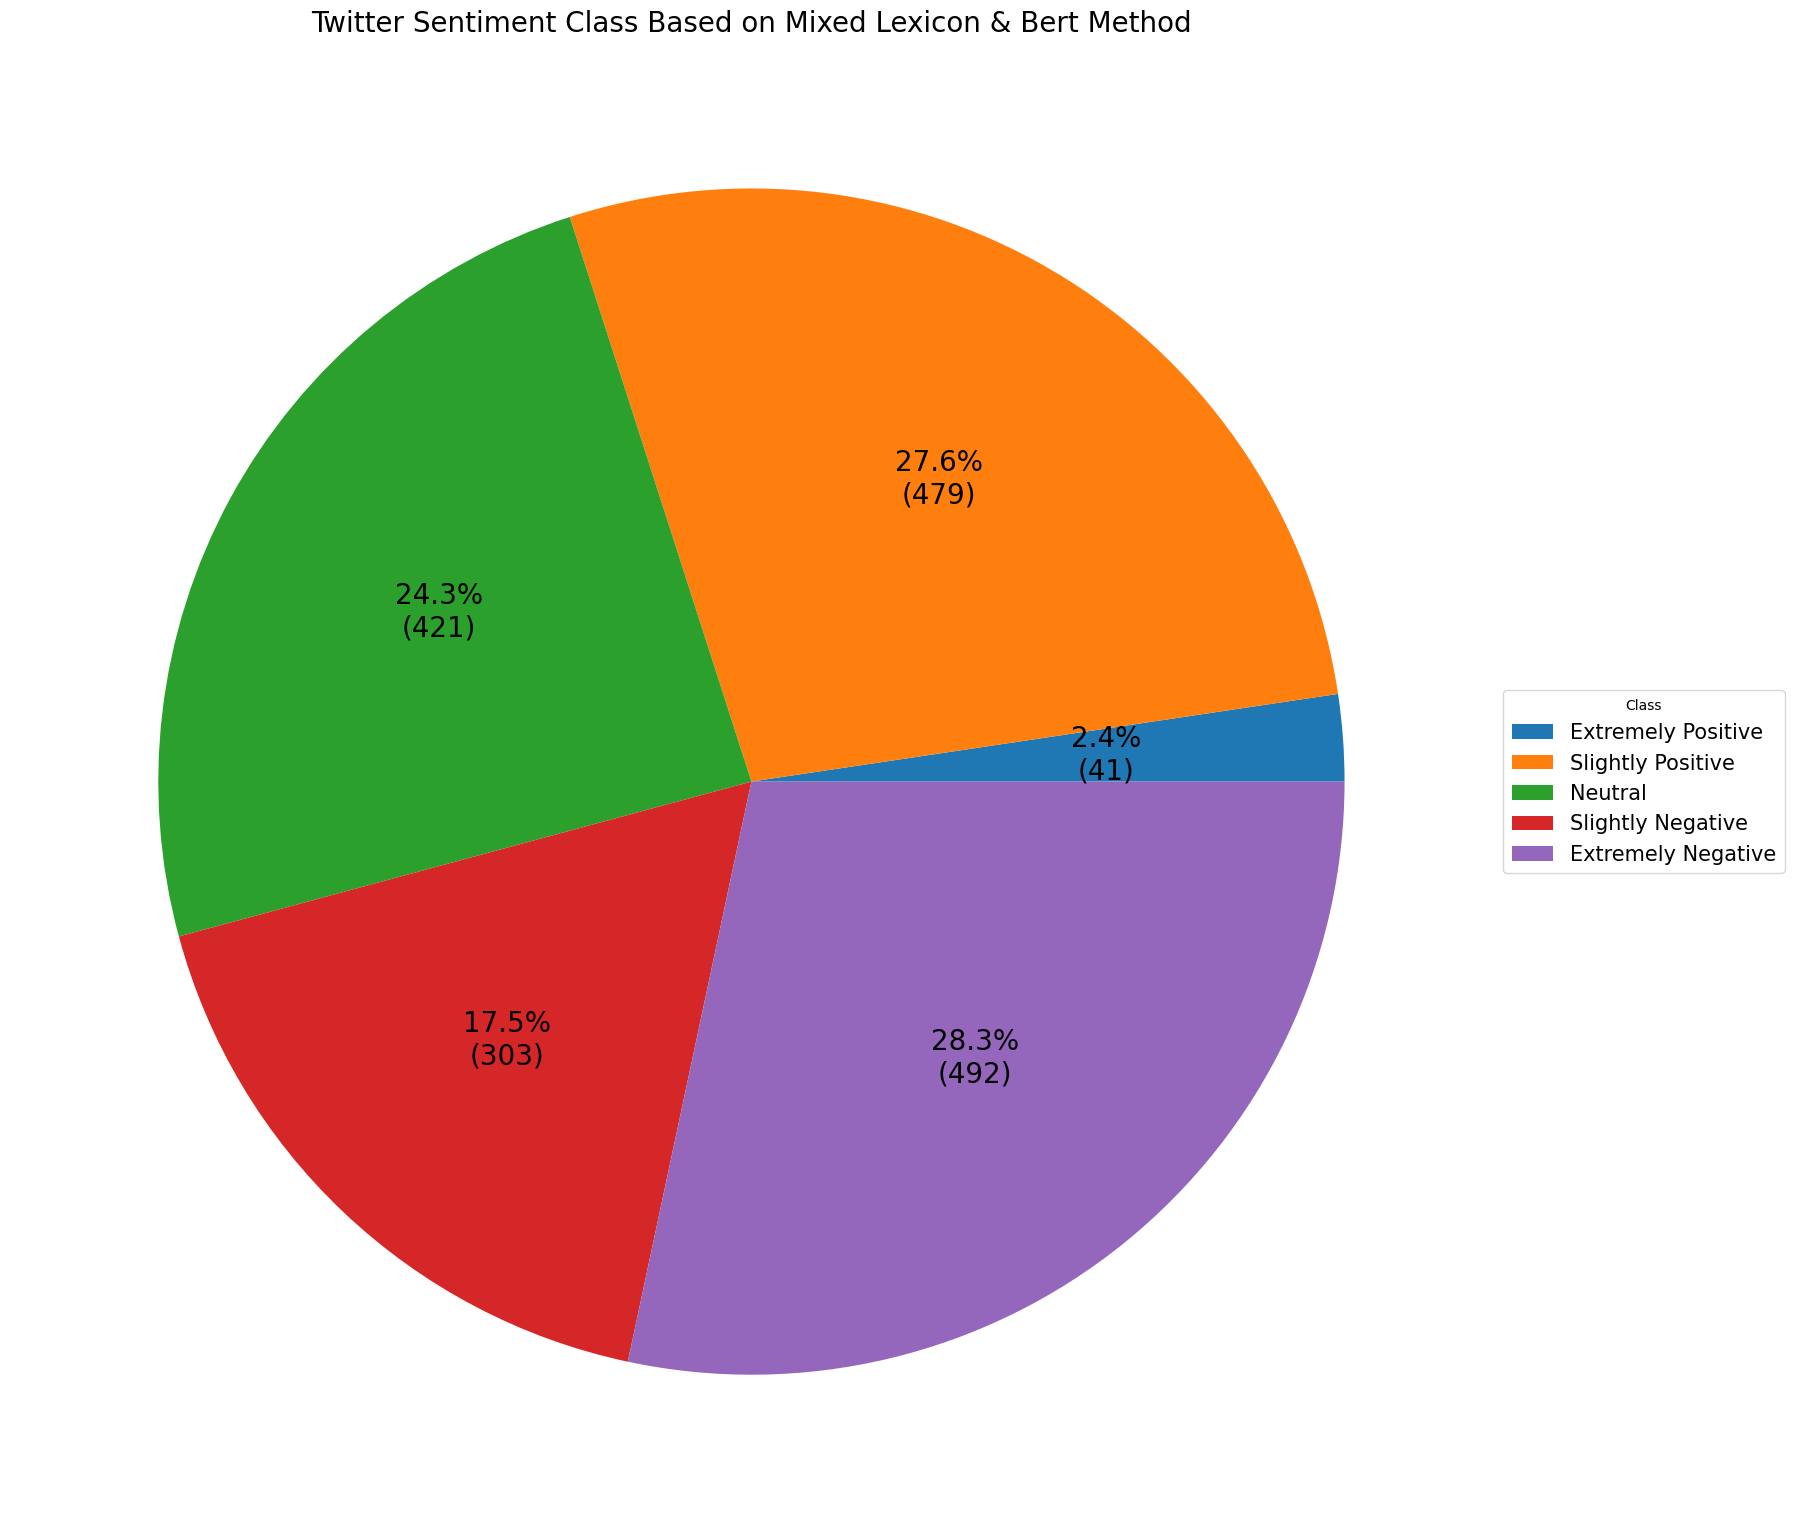

In [75]:
#Sentiment analysis visualization
print(Counter(raw_data['attitude']))
count=list(Counter(raw_data['attitude']).values())
#Sentiment analysis visualization
def piechart(picture, all_value):
    absolute = int(np.round(picture/100.*np.sum(all_value),decimals=4))
    return '{:.1f}%\n({:d})'.format(picture, absolute)

fig, (ax1) = plt.subplots(1,1, figsize=(18, 18))

label = ['Extremely Positive','Slightly Positive','Neutral','Slightly Negative','Extremely Negative']

wedges, texts, autotexts = ax1.pie(count, autopct=lambda picture: piechart(picture, count), textprops={'fontsize': 20})
ax1.legend(wedges, label,
          title='Class',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1),fontsize=15)
ax1.set_title('Twitter Sentiment Class Based on Mixed Lexicon & Bert Method', fontsize=20)

plt.tight_layout()
plt.show()

In [74]:
#Create dictionary and corpus through gram-making techniques
def gensimWord(whole_text):
  new_text = []
  for text in whole_text:
    new_text.append(gensim.utils.simple_preprocess(text, deacc=True))
  return new_text
raw_text = list(gensimWord(raw_data_text))

bigram_phrase=gensim.models.Phrases(raw_text, min_count=3, threshold=200,connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)
trigram_phrase=gensim.models.Phrases(bigram_phrase[raw_text], min_count=3, threshold=200,connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)

bigram_praser = gensim.models.phrases.Phraser(bigram_phrase)
trigram_praser = gensim.models.phrases.Phraser(trigram_phrase)

def createGrams(original_text,number,grams):
  if number==2:
    text=[grams[doc] for doc in original_text]
  elif number==3:
    text=[grams[bigram_praser[doc]] for doc in original_text]
  return text

tripdict=gensim.corpora.Dictionary(createGrams(raw_text,3,trigram_praser))
corpus_text=[tripdict.doc2bow(text) for text in createGrams(raw_text,3,trigram_praser)]
tfidf_text = gensim.models.TfidfModel(corpus_text, id2word=tripdict)
threshold = 0.02

for number in range(0, len(corpus_text)):
    bow_text = corpus_text[number]
    tfidf_ids_text = [id for id, value in tfidf_text[bow_text]]
    low_value_words= [id for id, value in tfidf_text[bow_text] if value < threshold]
    missing_words_in_tfidf = [id for id in bow_text if id not in tfidf_ids_text]
    new_bow_tweet = [b_item for b_item in bow_text if b_item not in low_value_words and low_value_words not in missing_words_in_tfidf]
    corpus_text[number] = new_bow_tweet

# Create LDA Model for topic aggregation
lda_model_tweet = gensim.models.ldamodel.LdaModel(corpus=corpus_text,
                                           id2word=tripdict,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=300,
                                           passes=20,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

#Visulized topic modeling for tweets
pyLDAvis.enable_notebook()
vis_tweet = pyLDAvis.gensim_models.prepare(lda_model_tweet, corpus_text, tripdict)
vis_tweet

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.492985 -0.050184       1        1  56.278886
5      0.030638  0.356930       2        1   8.309826
13     0.003934 -0.016725       3        1   6.091904
12    -0.020118 -0.021884       4        1   4.361362
4     -0.023803  0.022370       5        1   4.133890
9     -0.041853 -0.030748       6        1   3.053091
14    -0.041943 -0.032374       7        1   3.021788
6     -0.039276 -0.029741       8        1   2.887524
3     -0.046232 -0.032807       9        1   2.409733
1     -0.050201 -0.027822      10        1   1.812789
2     -0.051649 -0.026868      11        1   1.793326
11    -0.052499 -0.030220      12        1   1.607711
10    -0.053139 -0.029299      13        1   1.582106
8     -0.053380 -0.024025      14        1   1.470741
7     -0.053466 -0.026602      15        1   1.185322, topic_info=         Term         Freq        Total Category  logprob  loglift
8         car  1380.000000  1380.000000  Default  30.0000  30.0000
37      drive  1079.000000  1079.000000  Default  29.0000  29.0000
11      first    93.000000    93.000000  Default  28.0000  28.0000
187      land    91.000000    91.000000  Default  27.0000  27.0000
64        bus   470.000000   470.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
521    useful     0.917971     1.693490  Topic15  -5.8672   3.8228
797     telly     0.793544     1.569063  Topic15  -6.0128   3.7534
1265     boob     0.694127     1.469647  Topic15  -6.1467   3.6850
1272  wedding     0.693987     1.469506  Topic15  -6.1469   3.6849
43      worst     0.693566     1.469086  Topic15  -6.1475   3.6846

[507 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1849      9  0.770373   ability
97       11  0.854291  absolute
914      11  0.953738    access
1239      8  0.903449  accident
1224     13  0.713597     adult
...     ...       ...       ...
26        1  0.997039      year
798      15  0.862704       yer
442       6  0.955464      york
906      14  0.661176     youth
1597      9  0.833807        yr

[503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 14, 13, 5, 10, 15, 7, 4, 2, 3, 12, 11, 9, 8])

In [78]:
# Find synonyms of topics
economic_url='https://www.wordhippo.com/what-is/another-word-for/economic.html'
inflation_url='https://www.wordhippo.com/what-is/another-word-for/inflation.html'
cost_of_living_url='https://www.wordhippo.com/what-is/another-word-for/cost_of_living.html'
income_url='https://www.wordhippo.com/what-is/another-word-for/income.html'
redundancy_url='https://www.wordhippo.com/what-is/another-word-for/redundancy.html'
unemployment_url='https://www.wordhippo.com/what-is/another-word-for/unemployment.html'
second_hand_url='https://www.wordhippo.com/what-is/another-word-for/second_hand1.html'
electric_url='https://www.wordhippo.com/what-is/another-word-for/electric.html'
supply_url='https://www.wordhippo.com/what-is/another-word-for/supply.html'
supply_chain_url='https://www.wordhippo.com/what-is/another-word-for/supply_chain.html'
war_url='https://www.wordhippo.com/what-is/another-word-for/war.html'
policy=['action','administration','approach','arrangement','behavior','code',
        'guideline','management','method','plan','practice','program','protocol',
        'rule','scheme','strategy','theory','brexit','china','ukraine']

def keywordExtractAdd(url_name,location,number):
    page_name=r.get(url_name)
    soup_name=BS(page_name.content,'html.parser')
    key_soup=soup_name.find_all('div', class_='relatedwords')[location].find_all('div', class_='wb')
    list_name=[]
    for key in key_soup:
        new_key=key.find('a')['href'][:-5]
        new_key=puntuation_free_text(new_key)
        new_key=re.sub('_',' ',new_key)
        if len(new_key)>2:
            list_name.append(new_key)
    return list_name[:number]

economic_inflation_list=list(filter(None, list(set([sentence_lemon(word) for word in (keywordExtractAdd(economic_url,0,45)+keywordExtractAdd(inflation_url,0,30))]))))
cost_of_living_list=list(filter(None,list(set([sentence_lemon(word) for word in (keywordExtractAdd(cost_of_living_url,0,84))]))))
income_list=list(filter(None,list(set([sentence_lemon(word) for word in (keywordExtractAdd(income_url,0,46))]))))
redundancy_list=list(filter(None,list(set([sentence_lemon(word) for word in (keywordExtractAdd(redundancy_url,2,29)+keywordExtractAdd(unemployment_url,0,28))]))))
new_car_list=list(filter(None,list(set([sentence_lemon(word) for word in (keywordExtractAdd(second_hand_url,0,31)+keywordExtractAdd(electric_url,0,20))]))))
policy_war_list=list(filter(None,list(set([sentence_lemon(word) for word in (keywordExtractAdd(supply_url,0,36)+keywordExtractAdd(supply_chain_url,0,2)+keywordExtractAdd(war_url,0,42)+policy)]))))

#Topic building
def word_extension(extension):
    sym_str=' '.join(extension)
    sym_token=nlp(sym_str)
    extension_list=[]
    for num in range(len(sym_token)):
        token = sym_token[num]
        if token.tag_ in ['NN','NNP','VB','VBP','VBG','JJ','RB']:
            if token._.inflect('NN',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('NN',inflect_oov=True))
            if token._.inflect('NNP',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('NNP',inflect_oov=True))
            if token._.inflect('VB',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VB',inflect_oov=True))
            if token._.inflect('JJ',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('JJ',inflect_oov=True))
            if token._.inflect('RB',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('RB',inflect_oov=True))
            if token._.inflect('RB',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('RB',inflect_oov=True))
            if token._.inflect('VBG',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VBG',inflect_oov=True))
            if token._.inflect('VBD',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VBD',inflect_oov=True))
            if token._.inflect('VBN',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VBN',inflect_oov=True))
            if token._.inflect('VBP',inflect_oov=True)!=None:
                extension_list.append(token._.inflect('VBP',inflect_oov=True))
    return [text for text in list(set(extension_list)) if len(text)>=2]

economic_inflation_extension=word_extension(economic_inflation_list)
cost_of_living_extension=word_extension(cost_of_living_list)
income_extension=word_extension(income_list)
redundancy_extension=word_extension(redundancy_list)
new_car_extension=word_extension(new_car_list)
policy_war_extension=word_extension(policy_war_list)

putthemtogether=economic_inflation_extension+cost_of_living_extension+income_extension+redundancy_extension+new_car_extension+policy_war_extension

In [89]:
#Time-series analysis about Related Topics
def timeChange(time):
    return datetime.fromisoformat(time)
keyword_list=keylist_of_car
additional_list=putthemtogether
temporary_data=raw_data.copy(deep=True)
temporary_data['date']=temporary_data['created at'].apply(timeChange)
# All Data Inside
temporary_data['all_include']=temporary_data['new_text_data'].loc[temporary_data['new_text_data'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in additional_list]))
dftweetcount_all=temporary_data.groupby('date')['all_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_all = dftweetcount_all['date']
value_all = dftweetcount_all['count']
# Only tweets related to economic inflation
temporary_data['economic_inflation_include']=temporary_data['new_text_data'].loc[temporary_data['new_text_data'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in economic_inflation_extension]))
dftweetcount_economic_inflation=temporary_data.groupby('date')['economic_inflation_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_economic_inflation = dftweetcount_economic_inflation['date']
value_economic_inflation = dftweetcount_economic_inflation['count']
# Only tweets related to cost of living
temporary_data['cost_of_living_include']=temporary_data['new_text_data'].loc[temporary_data['new_text_data'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in cost_of_living_extension]))
dftweetcount_cost_of_living=temporary_data.groupby('date')['cost_of_living_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_cost_of_living = dftweetcount_cost_of_living['date']
value_cost_of_living = dftweetcount_cost_of_living['count']
# Only tweets related to income level
temporary_data['income_include']=temporary_data['new_text_data'].loc[temporary_data['new_text_data'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in income_extension]))
dftweetcount_income=temporary_data.groupby('date')['income_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_income = dftweetcount_income['date']
value_income = dftweetcount_income['count']
# Only tweets related to redundancy
temporary_data['redundancy_include']=temporary_data['new_text_data'].loc[temporary_data['new_text_data'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in redundancy_extension]))
dftweetcount_redundancy=temporary_data.groupby('date')['redundancy_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_redundancy = dftweetcount_redundancy['date']
value_redundancy = dftweetcount_redundancy['count']
# Only tweets related to new types of car
temporary_data['new_car_include']=temporary_data['new_text_data'].loc[temporary_data['new_text_data'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in new_car_extension]))
dftweetcount_new_car=temporary_data.groupby('date')['new_car_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_new_car = dftweetcount_new_car['date']
value_new_car = dftweetcount_new_car['count']
# Only tweets related to new types of car
temporary_data['policy_war_include']=temporary_data['new_text_data'].loc[temporary_data['new_text_data'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in policy_war_extension]))
dftweetcount_policy_war=temporary_data.groupby('date')['policy_war_include'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date_policy_war = dftweetcount_policy_war['date']
value_policy_war = dftweetcount_policy_war['count']

In [87]:
time=raw_data['created at'][0]

datetime.fromisoformat(time)

datetime.datetime(2020, 1, 1, 0, 21, 46, tzinfo=datetime.timezone.utc)

In [91]:
colname=['date_all','value_all','economic_inflation','cost_of_living','income_level','redundancy','new_car','policy_war']
graph_df=pd.concat([date_all,value_all,value_economic_inflation,value_cost_of_living,value_income,value_redundancy,value_new_car,value_policy_war],keys=colname,axis=1)
graph_df=graph_df.set_index(graph_df['date_all'].dt.strftime("%Y/%m/%d")) 

fig = go.Figure()
fig.add_traces(go.Bar(x=graph_df.index,y=graph_df['value_all'],name='Total Tweets Related to the Topics'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['economic_inflation'],name='Economic Inflation',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['cost_of_living'],name='Cost of Living',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['income_level'],name='Income Level',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['redundancy'],name='Redundancy',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['new_car'],name='New Car Type',mode='lines+markers'))
fig.add_trace(go.Scatter(x=graph_df.index,y=graph_df['policy_war'],name='Policies & Supply & War',mode='lines+markers'))
fig=fig.update_layout(
    title="The number of tweets related to car purchase during coivd from 2019 to 2021",
    xaxis_title="Time",
    yaxis_title="Related Tweets Count per Day",
    legend_title="Different Topics",
    font=dict(
        size=10,
        color="RebeccaPurple"
    ),
    width=1200,
    margin=go.Margin(
            l=0,
            r=0)
)
fig.show()

c:\Users\Kaiye Yang\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:405: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
def labelCreator(extension_list):
    label_list=[]
    label=None
    choice=None
    for text in raw_data['new_text_data']:
        if any([word in text for word in keyword_list])==True:
            choice=True
            if any([words in text for words in extension_list])==True:
                label=True
            else:
                label=False
        else:
            choice,label=False,False
        label_list.append(label)
    return label_list

raw_data.insert(loc=10, column='economic_inflation', value=labelCreator(economic_inflation_extension))
raw_data.insert(loc=11, column='cost_of_living', value=labelCreator(cost_of_living_extension))
raw_data.insert(loc=12, column='income', value=labelCreator(income_extension))
raw_data.insert(loc=13, column='redundancy', value=labelCreator(redundancy_extension))
raw_data.insert(loc=14, column='new_car', value=labelCreator(new_car_extension))
raw_data.insert(loc=15, column='policy_war', value=labelCreator(policy_war_extension))

In [ ]:
#Packages for machine learning models
# Skleran classifiers
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,classification_report
import featuretools as ft
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# Keras classifiers for ANN
import keras_metrics
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding,LSTM
from tensorflow.keras import layers
from keras.utils import np_utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
raw_data=pd.read_csv('C:/Users/ky002/Desktop/Dickens/Postgraduate/Dissertation/Programmes & Codes & Graphs/Data Source/final_tweet_data_v1.csv',sep=',',encoding='utf_8')
raw_data=raw_data.drop(['Unnamed: 0'],axis=1)
#Build independent variables and dependent variables for all data
#Get all binary, triple, and multi-dimensional data into dummies
raw_data['created at']=raw_data.iloc[:,1].str.slice(stop=4).map( {'2019': 0, '2020': 1, '2021': 2} ).astype(int)
raw_data['treatment/control']=raw_data.iloc[:,9].map( {'before covid': 0, 'after covid': 1}).astype(int)
raw_data['economic_inflation']=raw_data.iloc[:,10].map( {False: 0, True: 1}).astype(int)
raw_data['cost_of_living']=raw_data.iloc[:,11].map( {False: 0, True: 1}).astype(int)
raw_data['income_level']=raw_data.iloc[:,12].map( {False: 0, True: 1}).astype(int)
raw_data['reduendancy']=raw_data.iloc[:,13].map( {False: 0, True: 1}).astype(int)
raw_data['new_car_type']=raw_data.iloc[:,14].map( {False: 0, True: 1}).astype(int)
raw_data['policy_war']=raw_data.iloc[:,15].map( {False: 0, True: 1}).astype(int)
raw_data['gender']=raw_data.iloc[:,16].map( {'female': 0, 'male': 1}).astype(int)
location=pd.get_dummies(processed_data.iloc[:,17])
train_data_feature=pd.concat([raw_data['created at'],raw_data.iloc[:,9:16],location],axis=1)

raw_data['lexicon_based_sentiment']=processed_data.iloc[:,-2:-1].replace({'Extremely Positive':4,'Slightly Positive':3,'Neutral':2,'Slightly Negative':1,'Extremely Negative':0}).values.astype(int)
raw_data['bert_based_sentiment']=processed_data.iloc[:,-1:].replace({'Extremely Positive':4,'Slightly Positive':3,'Neutral':2,'Slightly Negative':1,'Extremely Negative':0}).values.astype(int)
raw_data['sentiment_result']=((raw_data['lexicon_based_sentiment']+raw_data['bert_based_sentiment'])/2).round(0)
matrix_sentiment_result=pd.get_dummies(raw_data['sentiment_result']).values.astype(int)
#feature generation
def feature_generation(sentiment_result)
    es = ft.EntitySet(id = 'dataframe')
    es=es.add_dataframe(dataframe_name='data_frame',dataframe=train_data_feature,index='index')
    feature_matrix,feature_defs= ft.dfs(
    entityset=es,
    target_dataframe_name='data_frame',
    trans_primitives = ['add_numeric', 'multiply_numeric'])
    new_feature_data=feature_matrix
    new_result_data=sentiment_result
    new_feature_train_data,new_result_train_data=new_feature_data,new_result_data
    return new_feature_train_data,new_result_train_data


all_X=feature_generation(raw_data['sentiment_result'])[0]
all_y=feature_generation(raw_data['sentiment_result'])[1]

all_matrix_X=feature_generation(matrix_sentiment_result)[0]
all_matrix_y=feature_generation(matrix_sentiment_result)[1]


#Split the dataset into training and test datasets
def trainTestGenerator(X,y):
    train_all_X, test_all_X, train_all_y, test_all_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=5)
    return train_all_X, test_all_X, train_all_y, test_all_y

#All data
train_all_X, test_all_X, train_all_y, test_all_y=trainTestGenerator(all_X,all_y)
train_matrix_X, test_matrix_X, train_matrix_y, test_matrix_y=trainTestGenerator(all_matrix_X,all_matrix_y)


In [ ]:
def report(classifier,train_X,test_X,train_y,test_y): 
    classifier.fit(train_X,train_y)
    train_score=classifier.score(train_X,train_y)
    cv_train_score=cross_val_score(classifier,train_X,train_y,cv=10,scoring='accuracy').mean()
    print('Training Accuracy: ',train_score)
    print('Training Accuracy CV: ',cv_train_score)
    accuracy=accuracy_score(test_y,classifier.predict(test_X))
    f1score=f1_score(test_y,classifier.predict(test_X),average='macro')
    precision=precision_score(test_y,classifier.predict(test_X),average='macro')
    recall=recall_score(test_y,classifier.predict(test_X),average='macro')
    print('Test Accuracy: ',accuracy)
    print('Test F1-score: ',f1score)
    print('Test Precision: ',precision)
    print('Test Recall: ',recall)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], np.round(y[i],decimals=3), ha = 'center',bbox = dict(facecolor = 'red', alpha =.8))
def feature_importance(classifer, title,train_X):
    if str(classifer)=='decision_tree' or str(classifer=='random_forest'):
        plt.figure(figsize=(20,5))
        plt.bar(train_X.columns,height=classifer.feature_importances_,color='blue',width=0.5)
        addlabels(train_X.columns, classifer.feature_importances_)
        plt.margins(x=0, tight=True)
        plt.xticks(rotation = 90)
        plt.xlabel('True label',fontsize=20)
        plt.ylabel('Predicted label',fontsize=20)
        plt.title(title,fontsize=25)
    return plt.show()
def heatmat(classifier,title,test_X,test_y):
    labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
    confusion = confusion_matrix(test_y,classifier.predict(test_X))
    sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
    plt.xlabel('True label',fontsize=20)
    plt.ylabel('Predicted label',fontsize=20)
    plt.title(title,fontsize=25)
    return plt.show()

In [ ]:
# Classification of Lexicon Sentiment Analysis
# Modelling
model_list=[KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30, p=1, n_jobs=-1),
            DecisionTreeClassifier(criterion='entropy',max_depth=4, max_features='log2', random_state=100),
            RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, max_features='log2', random_state=100, class_weight='balanced', n_jobs=-1),
            MultinomialNB(fit_prior=True),
            BaggingClassifier(base_estimator=SGDClassifier(loss='modified_huber', random_state=100, learning_rate='optimal', n_jobs=-1),n_estimators=19,random_state=100,n_jobs=-1),
            LinearSVC(penalty='l2',class_weight='balanced',random_state=100),
            Perceptron(penalty='l2',random_state=10),
            SGDClassifier(loss='squared_hinge',random_state=10),
            XGBClassifier(max_depth=10,objective='multi:softprob',eval_metric = 'auc', n_jobs=-1)]

for each_model in model_list:
    report(each_model,train_all_X, test_all_X, train_all_y, test_all_y)
    heatmat(each_model,'Confusion Matrix on '+re.match(r'[A-Za-z]+',f'{model}').group(0)+'Model',test_all_X, test_all_y)

#ANN Classifier
#32 units is the best solution
def buildAnnModel():
    unit=32
    ann_model = Sequential([
    tf.keras.Input(shape=(len(train_matrix_X.columns),)),
    layers.Dense(unit,activation='PReLU'),
    layers.Dense(unit,activation='PReLU'),
    layers.Dense(unit,activation='PReLU'),
    layers.Dropout(0.20),
    layers.Dense(5,activation='sigmoid')
    ])
    ann_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
    return ann_model

ann_model = buildAnnModel()
ann_model.fit(train_X, train_y, epochs=100, batch_size=32,verbose=0, validation_split = 0.20)

score=loss, accuracy, precision, recall = ann_model.evaluate(train_matrix_X, train_matrix_y, verbose=0)
print('training loss = ',score[0])
print('training accuracy= ', score[1])

crossValidation=KerasClassifier(buildAnnModel)
score=cross_val_score(estimator=crossValidation, X=train_matrix_X, y=train_matrix_y, cv=10).mean()
print('training accuracy CV 10 = ',score)

score=loss, accuracy, precision, recall = ann_model.evaluate(test_matrix_X, test_matrix_y, verbose=0)
print('test loss = ',score[0])
print('test accuracy= ', score[1])
print('test precision= ',score[2])
print('test recall= ',score[3])
print('test f1_score: ',(2*score[2]*score[3])/(score[2]+score[3]))

ypred = np.argmax(ann_model.predict(train_matrix_X, verbose=1),axis=1)
labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
confusion = confusion_matrix(np.argmax(test_matrix_y,axis=1),ypred)
sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
plt.xlabel('True label',fontsize=20)
plt.ylabel('Predicted label',fontsize=20)
plt.title('Confusion Matrix on ANN Classification Model based on Sentiment Results',fontsize=25)
plt.show()

# LSTM
def buildLstmModel():
    unit=32
    lstm_model = Sequential()
    lstm_model.add(Embedding(train_matrix_X.shape[0],train_matrix_X.shape[1]))
    lstm_model.add(LSTM(unit))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(unit, activation='PReLU'))
    lstm_model.add(Dense(unit, activation='PReLU'))
    lstm_model.add(Dense(unit, activation='PReLU'))
    lstm_model.add(Dropout(0.20))
    lstm_model.add(Dense(5, activation='sigmoid'))
    lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
    return lstm_model
lstm_model = buildLstmModel()
lstm_model.fit(train_matrix_X, train_matrix_y, epochs=100, batch_size=32,verbose=0, validation_split = 0.20)
score=loss, accuracy, precision, recall = lstm_model.evaluate(train_matrix_X, train_matrix_y, verbose=0)
print('training loss = ',score[0])
print('training accuracy= ', score[1])
crossValidation=KerasClassifier(buildLstmModel)
score=cross_val_score(estimator=crossValidation, X=train_matrix_X, y=train_matrix_y, cv=10).mean()
print('training accuracy CV 10 = ',score)
score=loss, accuracy, precision, recall = lstm_model.evaluate(train_matrix_X, test_matrix_y, verbose=0)
print('test loss = ',score[0])
print('test accuracy= ', score[1])
print('test precision= ',score[2])
print('test recall= ',score[3])
print('test f1_score: ',(2*score[2]*score[3])/(score[2]+score[3]))
ypred = np.argmax(lstm_model.predict(test_matrix_X, verbose=1),axis=1)
labels=['Extremely Negative','Slightly Negative','Neutral','Slightly Positive','Extremely Positive']
confusion = confusion_matrix(np.argmax(test_matrix_y,axis=1),ypred)
sns.heatmap(confusion,square = True, annot=True, fmt ='d',xticklabels=labels, yticklabels=labels) 
plt.xlabel('True label',fontsize=20)
plt.ylabel('Predicted label',fontsize=20)
plt.title('Confusion Matrix on LSTM Classification Model based on Lexicon Sentiment Results',fontsize=25)
plt.show()